# Connect crashes with libraries

of the sampled crashes

## Analysis

In [2]:
import pandas as pd
import utils.config as config
import numpy as np

df_mlerr_labels = pd.read_excel(config.path_default.joinpath('Manual_labeing/libraries/df_err_processed_pregroup_sampled4_resampled7.xlsx'),
                                sheet_name = "Del-All (repaired)",
                                keep_default_na=False)
df_mlerr_labels_mllibs_1 = pd.read_excel(config.path_default.joinpath('Manual_labeing/libraries/df_err_processed_pregroup_sampled4_resampled7.xlsx'),
                                sheet_name = "Del-1(libs_cause) (repaired)",
                                keep_default_na=False)
df_mlerr_labels_mllibs_2 = pd.read_excel(config.path_default.joinpath('Manual_labeing/libraries/df_err_processed_pregroup_sampled4_resampled7.xlsx'),
                                sheet_name = "Del-2(libs_cause) (repaired)",
                                keep_default_na=False)

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
# df_mlerr_labels_mllibs = df_mlerr_labels[df_mlerr_labels.label_if_ML_bug.isin(config.label_if_ML_bug["ML bug"])]
# df_mlerr_labels_mllibs = df_mlerr_labels[~df_mlerr_labels.label_root_cause.isin(config.label_root_cause["NB specific"]+
#                                   ["module not installed", "change of environment", "file/path not found or exist", "external control (window closed)", "settings(permission, environment)"]+
#                                   ["did not import", "undefined variable", "undefined function", "typo"])]

# matching config.top_lib_names
# could be multiple libs
libs_count = {}
n_libs = set()
def MLLib_counts(df_mlerr_labels_mllibs):
    for index, row in df_mlerr_labels_mllibs.iterrows():
        for libstr in row["Libs-cause"].split(","):
            lib = libstr.strip()
            if lib in ["keras", "tensorflow"]:
                if "tensorflow/keras" not in libs_count:
                    libs_count["tensorflow/keras"] = 0
                libs_count["tensorflow/keras"] += 1
            elif lib in (config.top_lib_names):
                n_libs.add(row["eid"])
                if lib not in libs_count:
                    libs_count[lib] = 0
                libs_count[lib] += 1
MLLib_counts(df_mlerr_labels_mllibs_1)
MLLib_counts(df_mlerr_labels_mllibs_2)
libs_count = dict(sorted(libs_count.items(), key=lambda item: item[1], reverse=True))
df_mllibs_cause = pd.DataFrame.from_dict(libs_count, orient='index', columns=["count"])

In [4]:
print("The percentage of crashes caused by using ML libraries: ", len(n_libs)/df_mlerr_labels.shape[0])
print("Top libraries that lead to crashes:")
df_mllibs_cause.iloc[:10]/sum(df_mllibs_cause["count"])*100

The percentage of crashes caused by using ML libraries:  0.3163538873994638
Top libraries that lead to crashes:


,count
pandas,21.355932
tensorflow/keras,19.661017
sklearn,17.288136
torch,10.847458
numpy,10.508475
matplotlib,6.101695
seaborn,4.406780
transformers,2.033898
cv2,1.694915
statsmodels,1.694915


In [1]:
import utils.imports_parser as imports_parser
import pandas as pd
import utils.config as config

res = imports_parser.get_imports_nbs_static(config.path_default.joinpath("Manual_labeing\sampled_nbs_resampled"), imports_parser.get_imports_line_outermost)
res_pd = pd.DataFrame.from_dict(res)
df_mllibs_frequency = res_pd.explode('imports', ignore_index=True).imports.value_counts()
df_mllibs_frequency = pd.DataFrame.from_dict(df_mllibs_frequency)
df_mllibs_frequency["frequency"] = df_mllibs_frequency["count"]/sum(df_mllibs_frequency["count"])*100

path_default=WindowsPath('C:/Users/yirwa29/Downloads/data_jupyter_nbs_empirical')
Successfully parsed 731/731 notebook files, failed 0 ones.


In [16]:
df_mllibs_frequency = df_mllibs_frequency[df_mllibs_frequency.index.isin(df_mllibs_cause.index)]
df_mllibs_cause = df_mllibs_cause.reindex(df_mllibs_frequency.index)
df_mllibs_cause["Lib Crashes"] = df_mllibs_cause["count"]/sum(df_mllibs_cause["count"])*100
df_mllibs_cause["Lib Usage"] = df_mllibs_frequency["frequency"].values

In [32]:
df_mllibs_cause["CF_ori"] = df_mllibs_cause["Lib Crashes"]/df_mllibs_cause["Lib Usage"]
df_mllibs_cause = df_mllibs_cause.sort_values(by='CF_ori', ascending=False)
df_mllibs_cause["CF"] = df_mllibs_cause["CF_ori"]/30*100 # normalized ratio

In [26]:
df_mllibs_cause.index = [
    "tensorflow\n(keras)" if i == 0 else label
    for i, label in enumerate(df_mllibs_cause.index)
]

In [22]:
# plot settings
import utils.Mycolor as Mycolor
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

mycolor = Mycolor.Mycolor()
cm_dp = mycolor.cm_dp

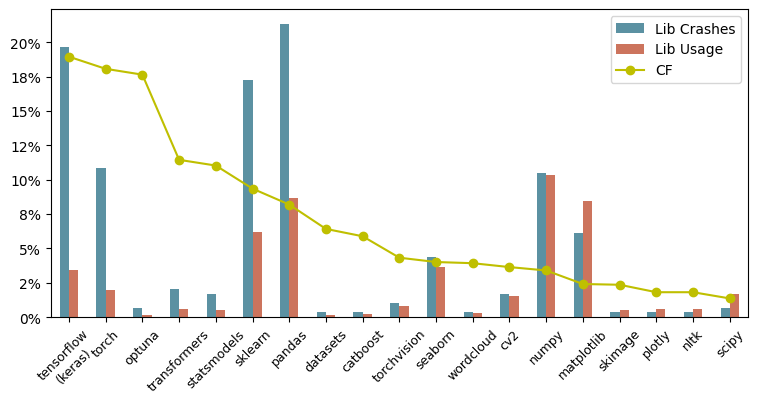

In [41]:
import matplotlib.pyplot as plt


ax = df_mllibs_cause.plot(y=["Lib Crashes", "Lib Usage"], kind="bar", color = [cm_dp(20),cm_dp(230)], figsize=(9,4))
df_mllibs_cause.plot(y=['CF'], linestyle='-', marker='o', ax=ax, color="y")
ax.tick_params(axis='x', labelsize=9, labelrotation=45)
ax.set_xlabel('')
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.savefig(config.path_plot_default.joinpath("library.pdf"), bbox_inches='tight')
plt.show()